### S2 Geometry

Original GitHub repo with instructions how to install the library: https://github.com/google/s2geometry
After setting it up, you should be able to install s2_py with `s2_py

In [1]:
import s2_py as s2
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
from shapely.geometry import Polygon, mapping

## California in S2 Cells

### Getting CA coordinates

In [2]:
# For S2 Loop coordinates need to be in CCW direction
ca_coord = pd.read_csv('./Data/CA_coord_ccw.txt', header=None, delim_whitespace=True)
ca_coord.columns = ['lat', 'long']
ca_coord.head()

,lat,long
0,41.9983,-124.40
1,41.7170,-124.45
2,41.2386,-124.34
3,41.0110,-124.31
4,40.4658,-124.65


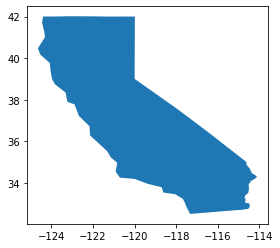

In [3]:
ca_polygon = Polygon(zip(ca_coord.long, ca_coord.lat))
crs = {'init': 'epsg:4326'}
ca_polygon2 = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[ca_polygon])  
ca_polygon2.plot()

In [5]:
ca_lats = ca_coord.lat.tolist()
ca_longs = ca_coord.long.tolist()

points = []
for i in range(len(ca_lats)):
    latlng = s2.S2LatLng.FromDegrees(ca_lats[i], ca_longs[i])
    points.append(latlng.ToPoint())
loop = s2.S2Loop(points)

S2 Cells sizes: http://s2geometry.io/resources/s2cell_statistics

In [376]:
type(loop)

s2_py.pywraps2.S2Loop

In [377]:
loop

<s2_py.pywraps2.S2Loop; proxy of <Swig Object of type 'S2Loop *' at 0x7fb4d4b8a6c0> >

In [6]:
coverer = s2.S2RegionCoverer()
coverer.set_min_level(12)
coverer.set_max_level(12)
# coverer.set_max_cells(500)
covering = coverer.GetCovering(loop)

In [7]:
type(covering), len(covering)

(tuple, 100076)

## Mapping CA and S2 Cells

Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php

In [10]:
usa_df = gpd.read_file("./Data/tl_2018_us_state/tl_2018_us_state.shp")
ca_df = usa_df[usa_df.NAME=='California']

In [375]:
ca_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
13,4,9,06,01779778,06,CA,California,00,G4000,A,403503931312,20463871877,+37.1551773,-119.5434183,"(POLYGON ((-124.136561 41.464452, -124.137892 ..."


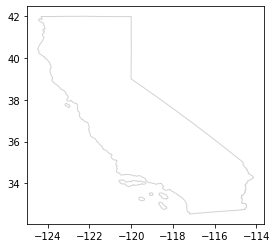

In [12]:
ca_df.plot(color='white', edgecolor='lightgrey')

In [ ]:
ca_polygon = Polygon(zip(ca_coord.long, ca_coord.lat))
crs = {'init': 'epsg:4326'}
ca_polygon2 = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[ca_polygon])  
ca_polygon2.plot()

In [16]:
geoms = []
for cellid in covering:
    new_cell = s2.S2Cell(cellid)
    vertices = []
    for i in range(4):
        vertex = new_cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append((latlng.lng().degrees(),
                         latlng.lat().degrees()))
    geo = Polygon(vertices)
    geoms.append(geo)

In [17]:
len(geoms)

100076

In [25]:
geoms_df = gpd.GeoDataFrame(crs=crs, geometry=geoms)  
geoms_df.shape

(100076, 1)

In [26]:
geoms_df.head()

,geometry
0,"POLYGON ((42.0211361095208 -121.4742601200827,..."
1,"POLYGON ((42.02063732859841 -121.538901534136,..."
2,POLYGON ((42.00668446866296 -121.5216871390368...
3,POLYGON ((42.01391278357534 -121.4979761458602...
4,POLYGON ((41.99995397496993 -121.4807815669189...


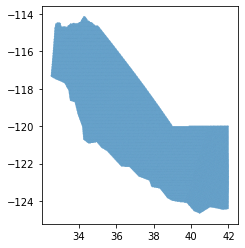

In [27]:
geoms_df.plot()

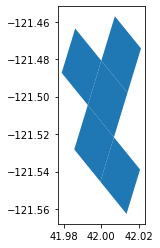

In [28]:
geoms_df.head().plot()

### Wildfire Perimeters Data

Source: https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/

In [91]:
hist_df = gpd.read_file("./Data/US_HIST_FIRE_PERIMTRS_DD83/US_HIST_FIRE_PERIMTRS_DD83.shp")
hist_df.head()

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
0,21999,2001,11059.673693,BACON POND,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G290,0.004912,0.464703,POLYGON ((-114.2894247559472 42.60646789757629...
1,22000,2001,72.801837,S WALCOTT,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G296,0.000032,0.033650,POLYGON ((-113.4203092376806 42.57474289596877...
2,22001,2001,15.452375,ROCK CREEK,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G303,0.000007,0.012800,POLYGON ((-114.3107468093172 42.38745396363043...
3,22002,2001,101.092962,I84MP246,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G308,0.000045,0.051676,POLYGON ((-113.1928317623754 42.31456795155066...
4,22003,2001,191.213671,HWY84MP18,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G312,0.000085,0.037007,POLYGON ((-113.4726872483172 42.54493802247265...


In [220]:
# some_polygon.exterior.coords.xy
# mapping(some_polygon)['coordinates']

In [92]:
hist_df.shape

(22437, 10)

In [94]:
hist_df['state'] = hist_df.unit_id.str[:2]

In [97]:
histCA = hist_df[hist_df.state=='CA']
histCA.shape

(4123, 11)

In [237]:
len(histCA.year_.value_counts())

19

In [236]:
histCA.year_.value_counts().sort_index()

2000    191
2001    215
2002    244
2003    326
2004    275
2005    328
2006    314
2007    329
2008    310
2009    228
2010    213
2011    134
2012    157
2013    263
2014     83
2015    124
2016     80
2017    208
2018    100
Name: year_, dtype: int64

In [223]:
histCA.head()

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry,state
5,22004,2004,875.495672,CORRAL HOLLOW,CA-SCU,{00000000-0000-0000-0000-000000000000},2004-CA-SCU-003829,0.000362,0.088920,POLYGON ((-121.4615643570089 37.67448202772431...,CA
42,22036,2009,24.907070,JORDAN,CA-,{00000000-0000-0000-0000-000000000000},2009-CA-8219,0.000010,0.013485,POLYGON ((-121.5537059656572 39.82813317021055...,CA
45,22039,2005,5.671372,SAND RIDGE,CA-AEU,{00000000-0000-0000-0000-000000000000},2005-CA-AEU-012102,0.000002,0.008193,"POLYGON ((-120.838737781323 38.58793648987802,...",CA
47,22041,2001,606.017858,VANDER-BOWEN,CA-,{00000000-0000-0000-0000-000000000000},2001-CA-,0.000244,0.073357,(POLYGON ((-118.9401591213458 35.9332321919130...,CA
67,22061,2005,432.821851,BAGLEY,CA-SHF,{00000000-0000-0000-0000-000000000000},2005-CA-SHF-002589,0.000188,0.067953,"POLYGON ((-122.028171947277 41.00204036117464,...",CA


#### Find wildfire with outlier coordinates

In [232]:
check_state = histCA.fire_num.tolist()
for i in check_state:
    state = i[5:7]
    if state != 'CA':
        print(i)

2002-CO-ARF-238
CA-MEU-008674


In [230]:
histCA[histCA.fire_num=='2002-CO-ARF-238']

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry,state
11894,35017,2002,5363.153501,BIG ELK,CA-ARF,{00000000-0000-0000-0000-000000000000},2002-CO-ARF-238,0.002299,0.239957,(POLYGON ((-105.4088618678803 40.3125788737169...,CA


In [231]:
histCA[histCA.fire_num=='CA-MEU-008674']

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry,state
21270,46984,2018,48920.399685,River,CAMEU,{E5297875-5551-479A-B839-93B16FF4EE6E},CA-MEU-008674,0.020602,1.000189,"POLYGON ((-123.0779419975246 39.1388385996226,...",CA


In [233]:
histCA = histCA[histCA.fire_num != '2002-CO-ARF-238']
histCA.shape

(4122, 11)

### Creating  a map for demo purposes

In [33]:
coverer_demo = s2.S2RegionCoverer()
coverer_demo.set_min_level(7)
coverer_demo.set_max_level(7)
# coverer.set_max_cells(500)
covering_demo = coverer_demo.GetCovering(loop)

In [34]:
len(covering_demo)

132

In [46]:
geoms_demo = []
for cellid in covering_demo:
    new_cell = s2.S2Cell(cellid)
    vertices = []
    for i in range(4):
        vertex = new_cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append((latlng.lng().degrees(),
                         latlng.lat().degrees()))
    geo = Polygon(vertices)
    geoms_demo.append(geo)

In [47]:
len(geoms_demo)

132

In [49]:
geoms_demo_df = gpd.GeoDataFrame(crs=crs, geometry=geoms_demo)  
geoms_demo_df.shape

(132, 1)

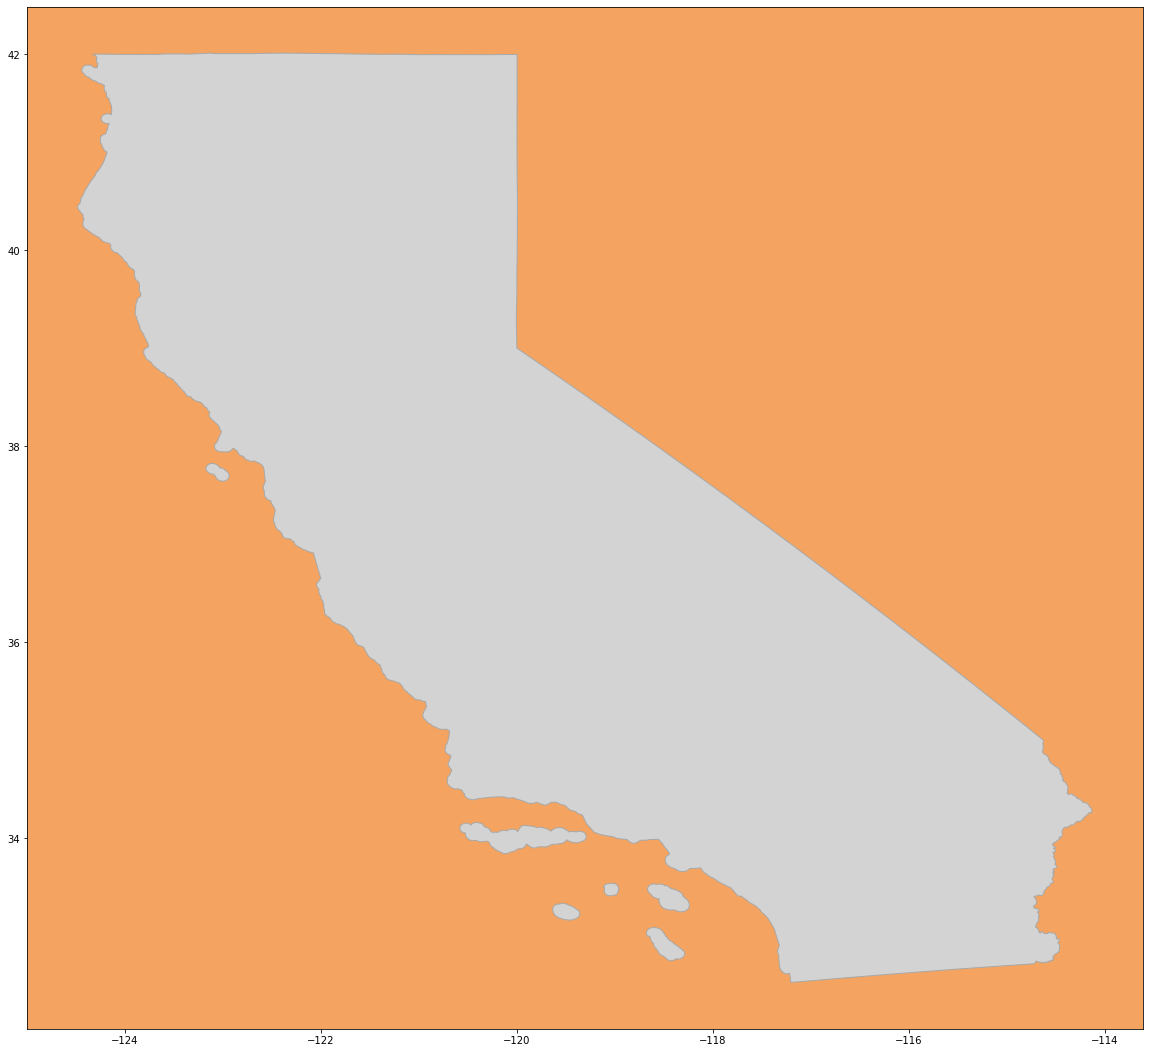

In [87]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
plt.show()

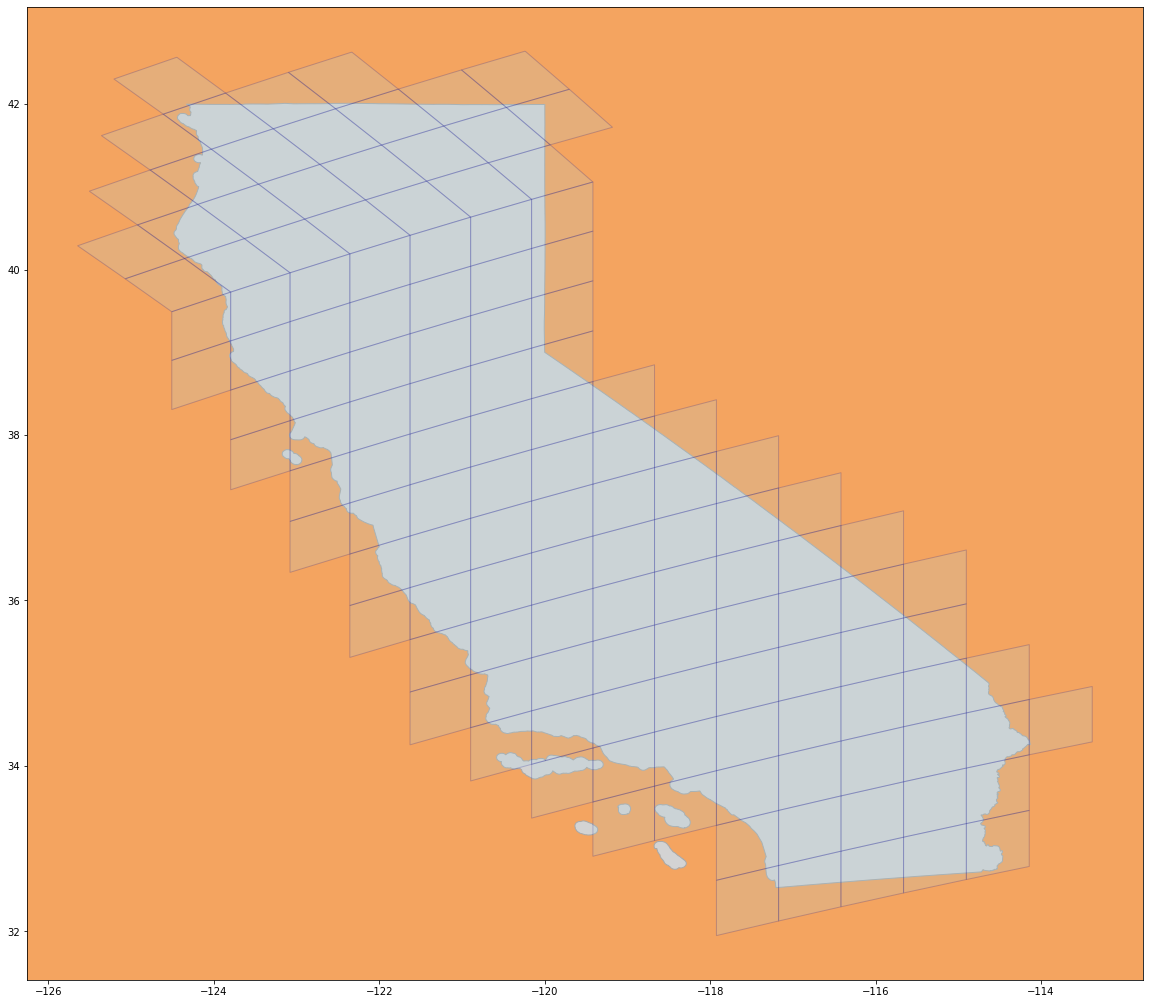

In [88]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
geoms_demo_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

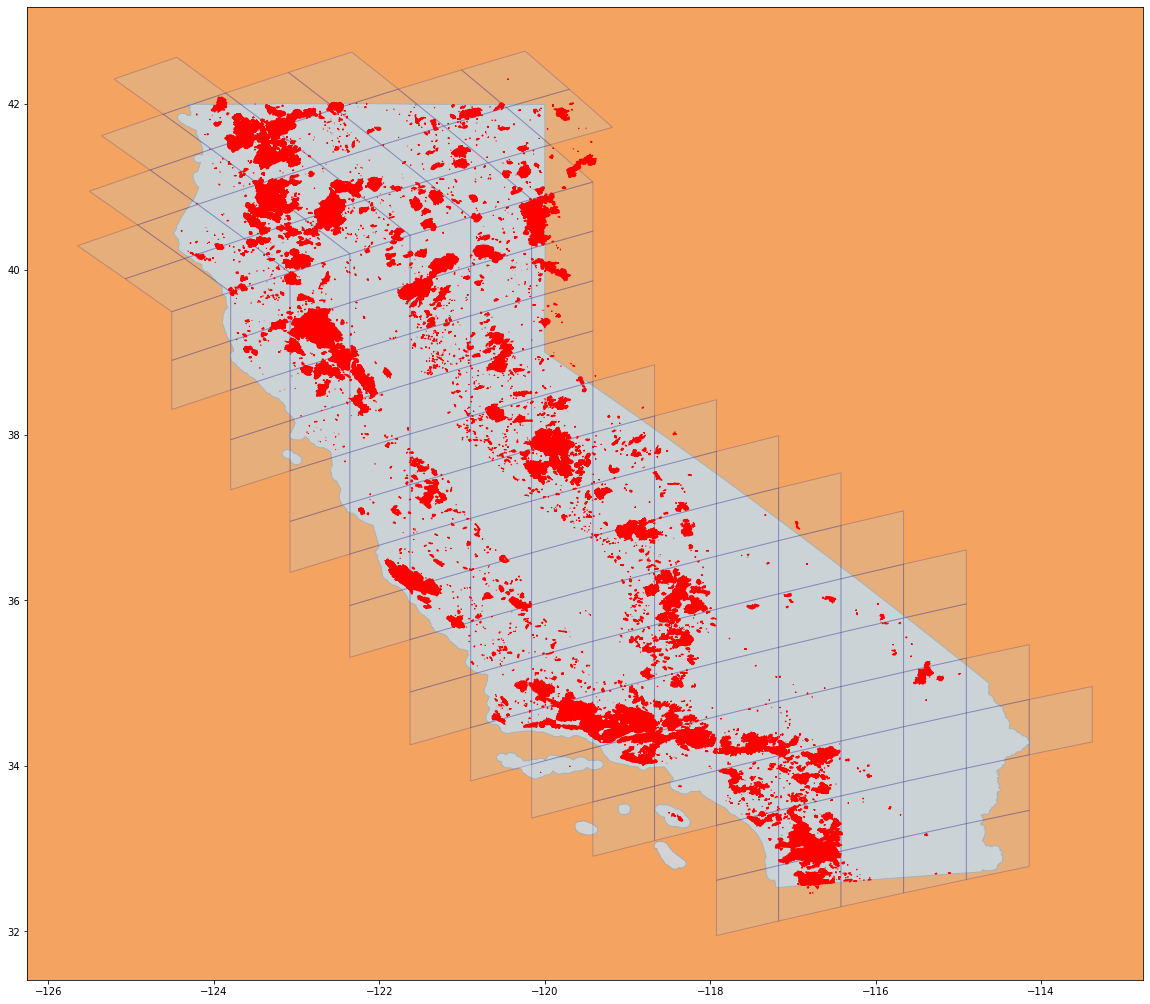

In [234]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
geoms_demo_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
histCA.plot(ax=ax, color='red', edgecolor='red')
plt.show()

## WildFire EDA

In [ ]:
# years = histCA.groupby('year_')
# N = len(histCA.year_.value_counts())
# cmap = plt.cm.get_cmap("hsv", N+1)

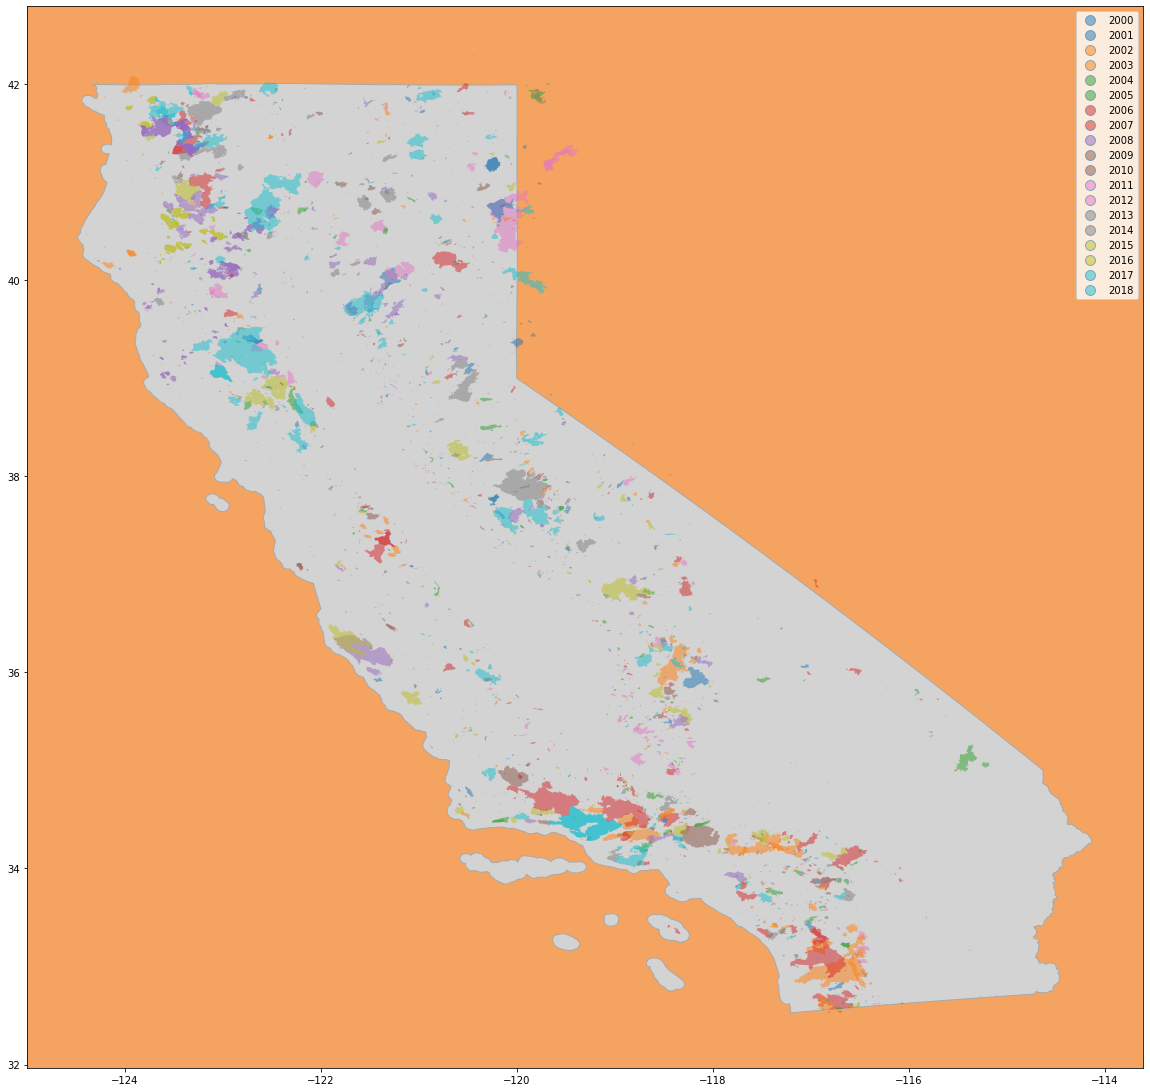

In [310]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', label='California', legend=True)
histCA.plot(ax=ax, column='year_', alpha=0.5, legend=True)
# ax.set_axis_off()
plt.show()

In [325]:
histCA_10_14_18 = histCA[histCA.year_.isin(['2010', '2014', '2018'])]
histCA_10_14_18.shape

(396, 11)

In [326]:
histCA_10_14_18.year_.value_counts().sort_index()

2010    213
2014     83
2018    100
Name: year_, dtype: int64

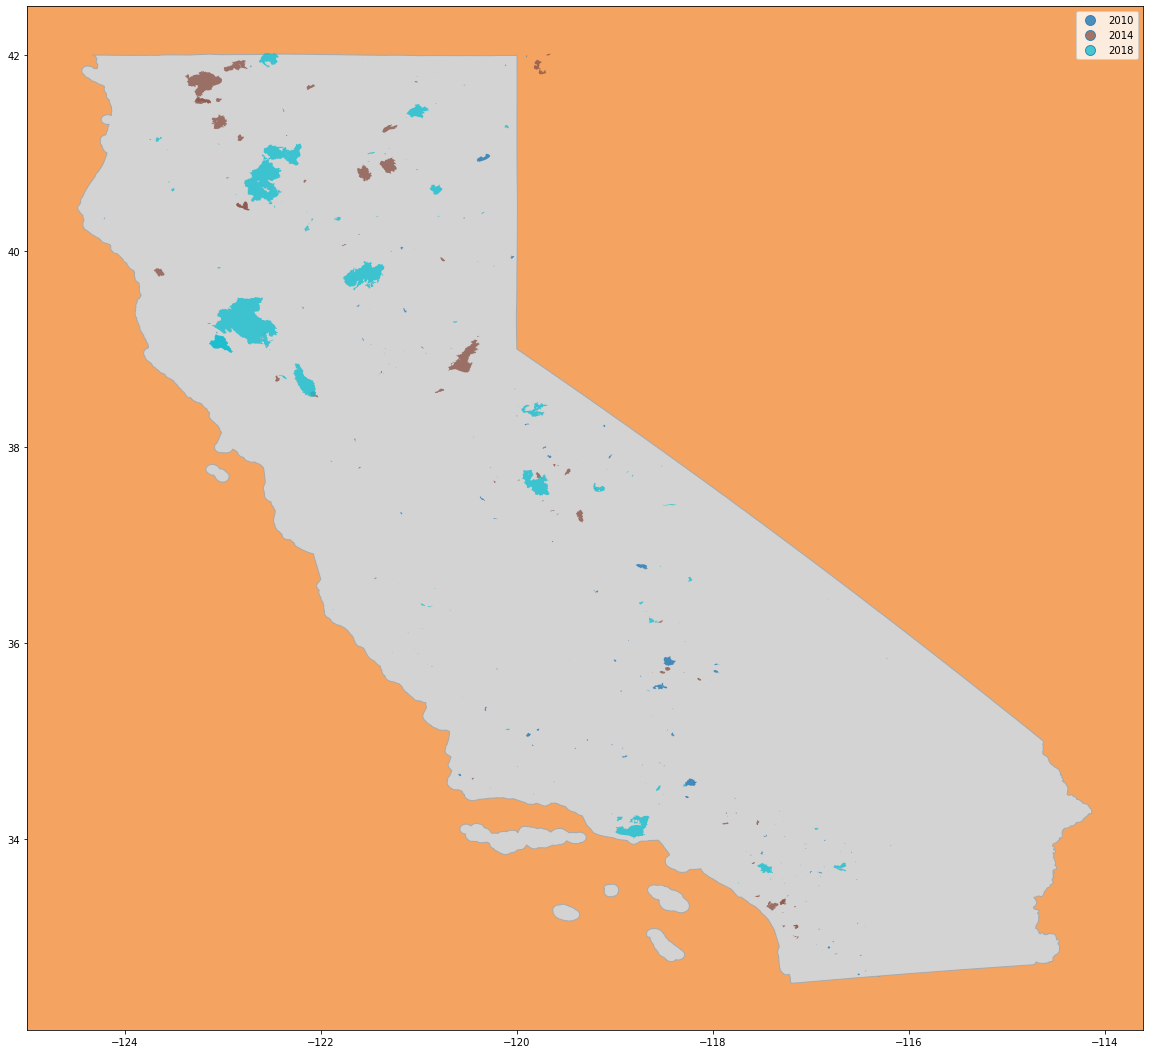

In [333]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
histCA_10_14_18.plot(ax=ax, column='year_', alpha=0.8, legend=True)
# ax.set_axis_off()
plt.show()

In [343]:
histCA['year'] = pd.to_numeric(histCA.year_)
fires_count = histCA.year.value_counts()
fires_area = histCA.groupby(['year']).acres.mean()

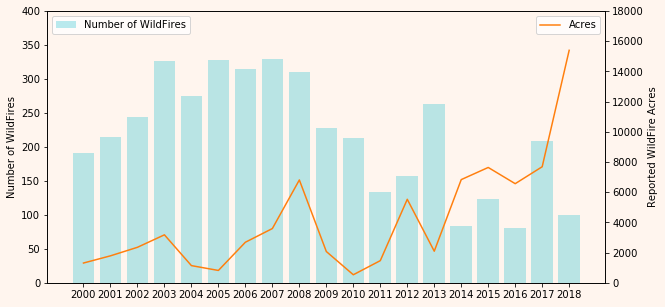

In [373]:
fig, ax1 = plt.subplots(figsize=(10,5))
fig.set_facecolor('seashell')
ax1.set_facecolor('seashell')
ax1.bar(fires_count.index, fires_count, color='tab:cyan', alpha=0.3, label='Number of WildFires')
ax1.set_xticks(range(2000,2019))
ax1.set_ylim(0, 400)
ax1.set_ylabel('Number of WildFires')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(fires_area, color='tab:orange', label='Acres')
ax2.set_ylim(0, 18000)
ax2.set_ylabel('Reported WildFire Acres')
ax2.legend()
plt.show()

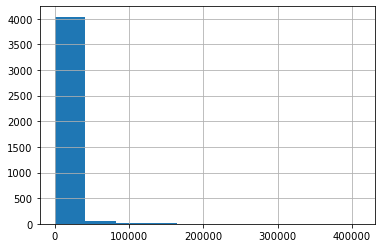

In [374]:
histCA.acres.hist()